Assignment:4
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

submission deadline till 9pm friday

submission instruction:
create your github repo and keep all the assisgnments over there(in that github repo)
i will share one googleform in group after completing your assignment you can share the github link through that google form. 

In [1]:
from typing import List, TypedDict, Annotated, Sequence
import operator
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq

### Create Vector DB for RAG operation

In [2]:
from langchain_community.document_loaders import WikipediaLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
#  Load the documents
docs = WikipediaLoader(query="India at the summer olympics", load_max_docs=35).load()
print(f"Number of documents loaded: {len(docs)}")

Number of documents loaded: 35


In [4]:
docs[0]

Document(metadata={'title': 'India at the Olympics', 'summary': "India first participated at the Olympic Games in 1900, becoming the first Asian nation to do so. Norman Pritchard represented the country and won two medals, both silver, in athletics. The nation first sent a team to the Summer Olympic Games in 1920 and has participated in every Summer Games since then. India has competed at several Winter Olympic Games after its debut in 1964.\nIndian athletes have won 41 medals, all at the Summer Games. At a period of time during the 1900s, the Indian men's field hockey team was dominant in the Olympic Games, winning eleven medals in twelve Olympics between 1928 and 1980 including eight gold medals of which six were won consecutively from 1928 to 1956. India's best performance happened at the 2020 Games, with seven medals including a gold and two silver.", 'source': 'https://en.wikipedia.org/wiki/India_at_the_Olympics'}, page_content="India first participated at the Olympic Games in 190

In [5]:
# Split the documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Maximum size of each chunk
    chunk_overlap=50  # Overlap to maintain context between chunks
)
split_docs = text_splitter.split_documents(docs)
print(f"Number of document chunks after splitting: {len(split_docs)}")

Number of document chunks after splitting: 269


In [6]:
#Set up the embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22956\1189955211.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
e:\practice\Agentic_AI_2.0\Assignements\agentic_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#Create an in-memory Chroma vector store and load the split documents
vector_store = Chroma.from_documents(
    documents=split_docs,
    embedding=embedding_model,
    collection_name="india_olympics"
)

#Verify the vector store
print(f"Number of documents in vector store: {vector_store._collection.count()}")

Number of documents in vector store: 269


In [8]:
query = "India's medals in summer olympics"
results = vector_store.similarity_search(query, k=2)
print("\nSample similarity search results:")
for doc in results:
    print(f"- {doc.page_content[:100]}... (Source: {doc.metadata['source']})")


Sample similarity search results:
- Indian athletes have won 41 medals, all at the Summer Games. At a period of time during the 1900s, t... (Source: https://en.wikipedia.org/wiki/India_at_the_Olympics)
- India competed at the 2016 Summer Olympics in Rio de Janeiro, Brazil, from 5 to 21 August 2016. Indi... (Source: https://en.wikipedia.org/wiki/India_at_the_2016_Summer_Olympics)


### Define AgentState class to maintain state of workflow

In [9]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### 1. Supervisor Node

In [10]:
##  Setting GROQ_API_KEY
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [11]:
## pydantic class for supervisor node output parser formatting
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [12]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [20]:
# model = ChatGroq(model="qwen/qwen3-32b")
model = ChatGroq(model="gemma2-9b-it")

In [21]:
def supervisor_node(state:AgentState):
    print(f"---- supervisor node ----- {state}")
    question=state["messages"][-1]

    print(f"Question:{question}")

    template = """
    You are a supervisor AI tasked with routing user queries to the correct module. You must classify each query into one of the following categories based on its requirement:

    - "llm" if it is a general, creative, or conversational question not needing external data.
    - "rag" if the query specifically relates to **India's performance or participation in the Summer Olympics** and should be answered using a Retrieval-Augmented Generation system.
    - "web" if the question requires real-time or up-to-date information from the internet.

    Strictly Only respond with one of the category names: llm, rag, or web.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    response = chain.invoke({"question":question})

    print(f"response from supervisor node : {response}")

    return {"messages":[response.Topic]}

In [22]:
supervisor_node({"messages":["Hi"]})

---- supervisor node ----- {'messages': ['Hi']}
Question:Hi
response from supervisor node : Topic='llm' Reasoning='General greeting, does not require specific knowledge or external data.'


{'messages': ['llm']}

### 2. router function

In [23]:
def call_router(state:AgentState):
    print(f"---- router function ----")
    topic = state["messages"][-1]
    print(f"topic recieved from supervisor node: {topic}")

    if "web" in topic.lower():
        return "WEB call"
    elif "rag" in topic.lower():
        return "RAG call"
    else:
        return "LLM call"

### 3. LLM function

In [24]:
chat_model = ChatGroq(model="llama3-8b-8192")

In [25]:
def llm_method(state:AgentState):
    print(f"---- LLM node ----")

    question = state["messages"][0]

    question_with_prompt="""
        You are a helpful and knowledgeable AI assistant.

        Answer the following user query as clearly and accurately as possible using your own reasoning and general knowledge.

        User question: """ + question

    response = chat_model.invoke(question_with_prompt)
    return {"messages": [response.content]}
    

### 4. Rag function

In [26]:
retriever=vector_store.as_retriever(search_kwargs={"k": 3})

In [27]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [28]:
def rag_method(state:AgentState):
    print("---- RAG node ----")

    question = state["messages"][0]
   
    template="""
    You are an expert assistant that uses provided context to answer the question accurately.

    Context:
    {context}

    User question: {question}

    Only use the above context to answer. If the context does not contain enough information, say "I don't have enough information to answer that.
    """

    prompt = PromptTemplate(
       template=template,
       input_variables=['context','question']
    )

    rag_chain = (
        {"context":retriever | format_docs, "question":RunnablePassthrough()}
        | prompt
        | chat_model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)
    print(f"Rag chain response: {result}")
    return {"messages":[result]}

### 5. Web crawler

In [29]:
from langchain_community.tools import DuckDuckGoSearchRun

In [30]:
search = DuckDuckGoSearchRun(return_direct=True)

In [31]:
search.invoke("Current president of India")

'Droupadi Murmu, who was born June 20, 1958, in Uparbeda, is the 15th president of India. She began her term in July 2022. Murmu is the first person from the tribal community, and the second woman after Pratibha Patil, to hold the office of president. She is also the first president to have been born in independent India as well as the youngest person to occupy the post. She previously served ... This is a list of current heads of state and heads of government. In some cases, mainly in presidential systems, one leader is head of state and head of government. ... India: President - Droupadi Murmu: Prime Minister - Narendra Modi He was the 5th President of India. Varahagiri Venkata Giri: Odisha: August 24th, 1969: August 24th, 1974: He was the 4th President of India. Mohammad Hidayatullah: Chhattisgarh: July 20th, 1969 ... He was the 14th and current President of India. He became the President on 25 July 2017 and is a member of the Bhartiya Janata Party. He is the former Governor of Biha

In [32]:
def web_crawler(state:AgentState):
    print(f"---- WEB Crawler ----")
    
    question = state["messages"][0]
    
    result = search.invoke(question)
    print(f"Web crawler result: {result}")
    
    return {"messages":[result]}

### 6. validation Node

In [33]:
class ValidateOutput(BaseModel):
    Validation: str = Field(description="Indicate whether the response is valid or invalid.")
    Reasoning: str = Field(description="Provide the reasoning behind the validation or invalidation of the response.")

In [34]:
validation_parser = PydanticOutputParser(pydantic_object=ValidateOutput)

In [35]:
def validation_router(state:AgentState):
    print(f"--- Validation router ---")
    
    validation = state["messages"][-1]
    if "invalid" in validation.lower():
        return "invalid response"
    else:
        return "valid response"

In [36]:
def validation_node(state:AgentState):
    print("---- validation node -----")
    response=state["messages"][-1]
    question=state["messages"][0]

    print(f" Question:{question}, \n Response:{response}")

    template = template = """
    Your task is to evaluate the relevance and correctness of a response generated by an AI system (RAG, LLM, or Web Crawler) based on the original user query.

    You must:
    1. Decide whether the response correctly and sufficiently answers the user query.
    2. If yes, mark it as **Valid**.
    3. If not, mark it as **Invalid**

    Respond strictly using the required format.

    User Query: {question}
    AI Response: {response}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question", "response"],
        partial_variables={"format_instructions":validation_parser.get_format_instructions()}
    )

    chain = prompt | model | validation_parser

    response = chain.invoke({"question":question, "response":response})

    print(f"response from supervisor node : {response}")

    return {"messages":[response.Validation]}

In [37]:
def final_output_node(state:AgentState):
    print(f"---- final output ----")
    print(f" Question: {state['messages'][0]} \n final Answer: {state['messages'][-1]}")

### 7. Workflow

In [38]:
from langgraph.graph import StateGraph,END

workflow=StateGraph(AgentState)

# Add nodes
workflow.add_node("Supervisor", supervisor_node)
workflow.add_node("RAG", rag_method)
workflow.add_node("LLM", llm_method)
workflow.add_node("WEB", web_crawler)
workflow.add_node("Validation", validation_node)
workflow.add_node("final_output", final_output_node)


# Set the entry point
workflow.set_entry_point("Supervisor")

# Add conditional edges from Supervisor to RAG/LLM/WEB
workflow.add_conditional_edges(
    "Supervisor",
    call_router,
    {
        "RAG call": "RAG",
        "LLM call": "LLM",
        "WEB call": "WEB"
    }
)

# Add edges from RAG/LLM/WEB to Validation
workflow.add_edge("RAG", "Validation")
workflow.add_edge("LLM", "Validation")
workflow.add_edge("WEB", "Validation")

# Add conditional edges from Validation to END or Supervisor
workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "invalid response": "Supervisor",
        "valid response": "final_output"
    }
)

workflow.add_edge("final_output", END)

In [39]:
app=workflow.compile()

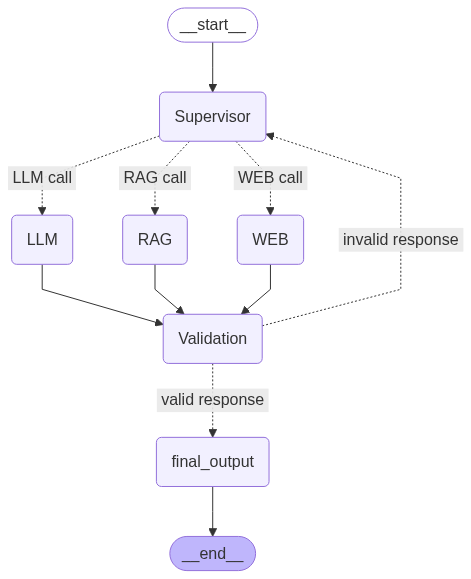

In [40]:
app

### Workflow testing

In [41]:
state = {"messages": ["Hello"]}
app.invoke(state)

---- supervisor node ----- {'messages': ['Hello']}
Question:Hello
response from supervisor node : Topic='llm' Reasoning='General greeting, no specific topic or external information required.'
---- router function ----
topic recieved from supervisor node: llm
---- LLM node ----
---- validation node -----
 Question:Hello, 
 Response:Hello! It's great to connect with you! Is there something I can help you with or would you like to chat about something in particular? I'm here to assist you with any questions or topics you'd like to discuss.
response from supervisor node : Validation='Valid' Reasoning="The AI response acknowledges the user's greeting and initiates a conversation by asking if the user has any questions or topics they'd like to discuss. This is a natural and appropriate response to a simple greeting."
--- Validation router ---
---- final output ----
 Question: Hello 
 final Answer: Valid


{'messages': ['Hello',
  'llm',
  "Hello! It's great to connect with you! Is there something I can help you with or would you like to chat about something in particular? I'm here to assist you with any questions or topics you'd like to discuss.",
  'Valid']}

In [42]:
state = {"messages":["Who won first olympic medal for India"]}
app.invoke(state)

---- supervisor node ----- {'messages': ['Who won first olympic medal for India']}
Question:Who won first olympic medal for India
response from supervisor node : Topic='rag' Reasoning="The query asks about India's performance in the Olympics"
---- router function ----
topic recieved from supervisor node: rag
---- RAG node ----
Rag chain response: According to the provided context, Norman Pritchard won the first Olympic medal for India, specifically two silver medals in athletics, at the 1900 Summer Olympics in Paris, France.
---- validation node -----
 Question:Who won first olympic medal for India, 
 Response:According to the provided context, Norman Pritchard won the first Olympic medal for India, specifically two silver medals in athletics, at the 1900 Summer Olympics in Paris, France.
response from supervisor node : Validation='Valid' Reasoning='The AI response correctly identifies Norman Pritchard as the first Indian Olympic medalist and provides the details of his achievement: tw

{'messages': ['Who won first olympic medal for India',
  'rag',
  'According to the provided context, Norman Pritchard won the first Olympic medal for India, specifically two silver medals in athletics, at the 1900 Summer Olympics in Paris, France.',
  'Valid']}

In [43]:
state = {"messages":["Who is the president of India"]}
app.invoke(state)

---- supervisor node ----- {'messages': ['Who is the president of India']}
Question:Who is the president of India
response from supervisor node : Topic='web' Reasoning='Requires real-time information'
---- router function ----
topic recieved from supervisor node: web
---- WEB Crawler ----
Web crawler result: List of all presidents of India from 1947 to 2025: Draupadi Murmu is serving as the 15th President of India and is the first tribal woman to occupy the top constitutional post in the country.With ... He was the 5th President of India. Varahagiri Venkata Giri: Odisha: August 24th, 1969: August 24th, 1974: He was the 4th President of India. Mohammad Hidayatullah: Chhattisgarh: July 20th, 1969 ... Droupadi Murmu, who was born June 20, 1958, in Uparbeda, is the 15th president of India. She began her term in July 2022. Murmu is the first person from the tribal community, and the second woman after Pratibha Patil, to hold the office of president. She is also the first president to have b

{'messages': ['Who is the president of India',
  'web',
  "List of all presidents of India from 1947 to 2025: Draupadi Murmu is serving as the 15th President of India and is the first tribal woman to occupy the top constitutional post in the country.With ... He was the 5th President of India. Varahagiri Venkata Giri: Odisha: August 24th, 1969: August 24th, 1974: He was the 4th President of India. Mohammad Hidayatullah: Chhattisgarh: July 20th, 1969 ... Droupadi Murmu, who was born June 20, 1958, in Uparbeda, is the 15th president of India. She began her term in July 2022. Murmu is the first person from the tribal community, and the second woman after Pratibha Patil, to hold the office of president. She is also the first president to have been born in independent India as well as the youngest person to occupy the post. She previously served ... Droupadi Murmu is an Indian politician and the first woman President of India, elected in 2022. She was born in Odisha, served as the Governor o

In [44]:
state = {"messages":["How to install pandas in python"]}
app.invoke(state)

---- supervisor node ----- {'messages': ['How to install pandas in python']}
Question:How to install pandas in python
response from supervisor node : Topic='web' Reasoning='Installing software packages requires real-time information and instructions which are best found on the internet.'
---- router function ----
topic recieved from supervisor node: web
---- WEB Crawler ----
Web crawler result: Learn different methods to install Pandas using pip or conda and verify your installation with a simple DataFrame creation. Find troubleshooting tips for common issues and links to related tutorials on working with Excel and CSV files. To install Pandas, run the following command: pip install pandas. To use Pandas in your code, import it with: ... Python is a great language for doing data analysis, primarily because of the fantastic ecosystem of data-centric python packages. Pandas is one of those packages and makes importing and analyzing data much easier. Pandas Index.to ... Learn how to insta

{'messages': ['How to install pandas in python',
  'web',
  "Learn different methods to install Pandas using pip or conda and verify your installation with a simple DataFrame creation. Find troubleshooting tips for common issues and links to related tutorials on working with Excel and CSV files. To install Pandas, run the following command: pip install pandas. To use Pandas in your code, import it with: ... Python is a great language for doing data analysis, primarily because of the fantastic ecosystem of data-centric python packages. Pandas is one of those packages and makes importing and analyzing data much easier. Pandas Index.to ... Learn how to install Pandas, a popular Python library for data analysis and manipulation, using pip, Anaconda, or from the source. Follow the steps, requirements, and troubleshooting tips for each method. Here's how you can install a specific version of Pandas: pip install pandas==1.4.2 Installing from a URL. If the package you need isn't available on P